# A2C Pendulum_v1 , 原始的A2C在倒立摆上的效果很不好，但是代码方法应该没问题

In [13]:
import gymnasium as gym  #1.1.1
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
try:
    device = torch.device("cuda:0")
    torch.zeros(1).to(device)
    print(f"成功使用 GPU: {torch.cuda.get_device_name(0)}")
except Exception as e:
    raise RuntimeError(f"无法正常使用 GPU 0: {e} 。")

成功使用 GPU: NVIDIA GeForce RTX 4050 Laptop GPU


# 环境 Pendulum-V1

In [15]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
# 输入环境的动作应是一维np.array,float32。环境输出的状态是一维的np.array,包含3个数。
env.reset(seed=0)
env.step([100])

(array([0.6364055 , 0.7713547 , 0.40822718], dtype=float32),
 -0.7657553092739346,
 False,
 False,
 {})

In [16]:
env.reset(seed=0)
env.step([2])

(array([0.6364055 , 0.7713547 , 0.40822718], dtype=float32),
 -0.7657553092739346,
 False,
 False,
 {})

# 定义网络

In [17]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))   # 乘2是因为Pendulum_v1的动作范围是[-2,2]
        std = F.softplus(self.fc_std(x))
        return mu, std
    #这个网络是2头的，一头是均值，一头是标准差，动作是x维的，均值头就输出x个均值，标准差头就输出x个标准差。对吗?是的，这是个2头的策略网络。
    # 如果是在update中被调用，传入的就是二维的tensor,(episode_length行，1列),每一个就是这个episode访问的每一个状态，输出的就是(episode_length行，1列)
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)    # 输出的是一维tensor

# Advantage Actor Critic

In [18]:
class A2C:
    def __init__(self, state_dim, hidden_dim, action_dim,actor_lr, critic_lr, gamma, device):

        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):     # 这里传入的state就是环境输出的state,一维np.array,(3,)
        state = torch.tensor(state.reshape(1,-1)).float().to(self.device)
        # 环境输出的state是一维的np.array,3个数，转为tensor,然后加一个维度，变成1*3的二维tensor。
        mu, std = self.actor(state)   #均值和标准差,都是(1行,action_dim列)的二维tensor
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        return action.item()  # 输出的是个标量

    def update(self, transition_dict):
        states = torch.tensor( np.array(transition_dict['states'] ),dtype=torch.float).to(self.device)
        # transition_dict['states']是[np.array([a,b,c]),np.array...]这样的,转成二维tensor了，每一行就是这个episode访问过的每一个state
        actions = torch.tensor( np.array(transition_dict['actions'] ),dtype=torch.float).to(self.device)
        # transition_dict['actions']是[np.array[a1],np.array([a2]),...]这样的,
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device) #转成一列，2维的
        next_states = torch.tensor(np.array(transition_dict['next_states']),dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)     #转成一列，2维的

        # ===== Critic =====
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)

        # ===== Actor =====
        mu, std = self.actor(states)     # 都是episode_length行，action_dim列，这里就是1列
        distribution = torch.distributions.Normal(mu, std)  # 构建高斯分布
        log_probability = distribution.log_prob(actions)     # 连续动作概率，有个对数是因为更新公式
        log_probability = log_probability.sum(dim=1, keepdim=True)

        actor_loss = -(log_probability * td_delta.detach()).mean()
        critic_loss = F.mse_loss(self.critic(states), td_target.detach())

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.step()

# 训练函数

In [19]:
def train_a2c(env, agent, num_episodes):
    episode_return = []

    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:

            for i_episode in range(int(num_episodes/10)):
                state, _ = env.reset()          # 环境输出的state是一维np.array,(3,)
                done = False
                total_reward = 0.0

                # 用于存储一条完整轨迹
                transition_dict = {'states': [],'actions': [],'rewards': [],'next_states': [],'dones': []}

                while not done:
                    # 选择动作
                    action = agent.take_action(state)       # 得到的action是个标量
                    next_state, reward, terminated, truncated, _ = env.step(np.array([action]))  # next_state是一维np.array,(3,) ,reward是个标量
                    done = terminated or truncated

                    transition_dict['states'].append(state)    # 保存数据
                    transition_dict['actions'].append(  np.array([action])  )  # 注意 shape (1,) 对应 view(-1,1)
                    transition_dict['rewards'].append(reward)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['dones'].append(done)

                    state = next_state
                    total_reward += reward

                agent.update(transition_dict)  # 用这一条轨迹更新网络
                episode_return.append(total_reward)

                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1),
                                      'return': '%.3f' % np.mean(episode_return[-10:])})
                pbar.update(1)

    return episode_return

# 开始训练

In [20]:
state_dim=3
hidden_dim = 128
action_dim = 1
actor_lr = 1e-4
critic_lr = 3e-3
gamma = 0.99
a2c = A2C(state_dim, hidden_dim, action_dim,actor_lr, critic_lr, gamma, device)

In [21]:
num_episodes = 500
episode_return = train_a2c(env, a2c, num_episodes)

Iteration 9: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it, episode=500, return=-1442.810]


# 训练结束

## 保存policy网络参数

In [22]:
torch.save(a2c.actor.state_dict(), "a2c_pendulum_policy_net.pth")

## 绘图

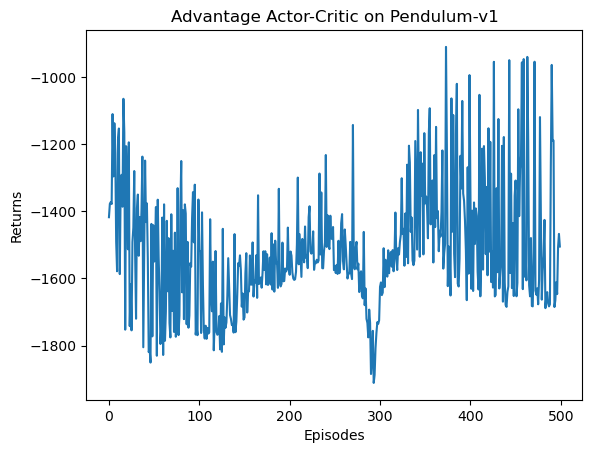

In [23]:
episodes_list = list(range(len(episode_return)))
plt.plot(episodes_list, episode_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Advantage Actor-Critic on {}'.format(env_name))
plt.show()